# Unsupervised Learning

### Practical 3 (Solutions)

The purpose of this computer lab is to illustrate how clustering methods, such as Gaussian mixtures or k-means, can be used for the segmentation of images.


#### Reading in images

The first task in any image analysis is, clearly, to read the image in.

We will need two R packages to help us a bit: One to "open" the images, and one to rearrange the data imported from them. Please load the two following packages. 

In [1]:
require(OpenImageR)
require(arrayhelpers)

Loading required package: OpenImageR

Loading required package: arrayhelpers

Package arrayhelpers, version 1.1-0

If you use this package please cite it appropriately.
   citation("arrayhelpers")
will give you the correct reference.

The project homepage is http://arrayhelpers.r-forge.r-project.org/





Now we download, open, and visualize an exemplary image.


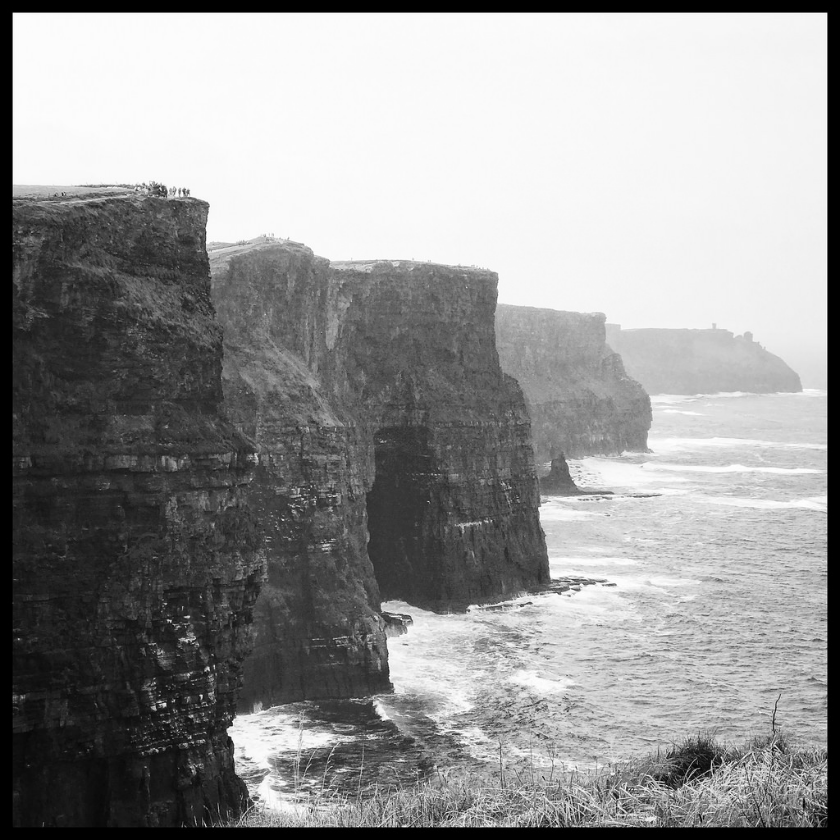

In [2]:
download.file("http://www.maths.dur.ac.uk/~dma0je/PG/Mix/cliffs.jpg", destfile="cliffs.jpg", mode="wb")
cliffs0 <- readImage("cliffs.jpg")
imageShow(cliffs0)

It is useful to understand a few things about image files here.  On a basic level we distinguish grey scale and color images.

**Grey scale images** will usually either come

  * as a matrix (such as 1024 x 1024) of grey scale values between 0 and 1, where 1=white and 0=black 
  * or as a pseudo-color image which consists of three identical copies of the grey scale image; for instance for the object `cliffs0` we have:

In [3]:
dim(cliffs0)

[1] 1024 1024    3

Now, note that all three layers contain the same content; e.g. 

In [4]:
sum(cliffs0[,,1]==cliffs0[,,2])

[1] 1048576

In terms of the plotting, should be said that `imageShow` has taken out some of the difficulty here. There is a deeper-laying twist: A matrix value [i,j] is defined by running the index `i` *downwards vertically*, then  `j` *rightwards horizontally*. However, an image coordinate is defined by a horizontal coordinate, then a vertical (upwards) coordinate. The function `imageShow` has carried out this transformation in the background. If we hadn't this available, we would need to do this manually:

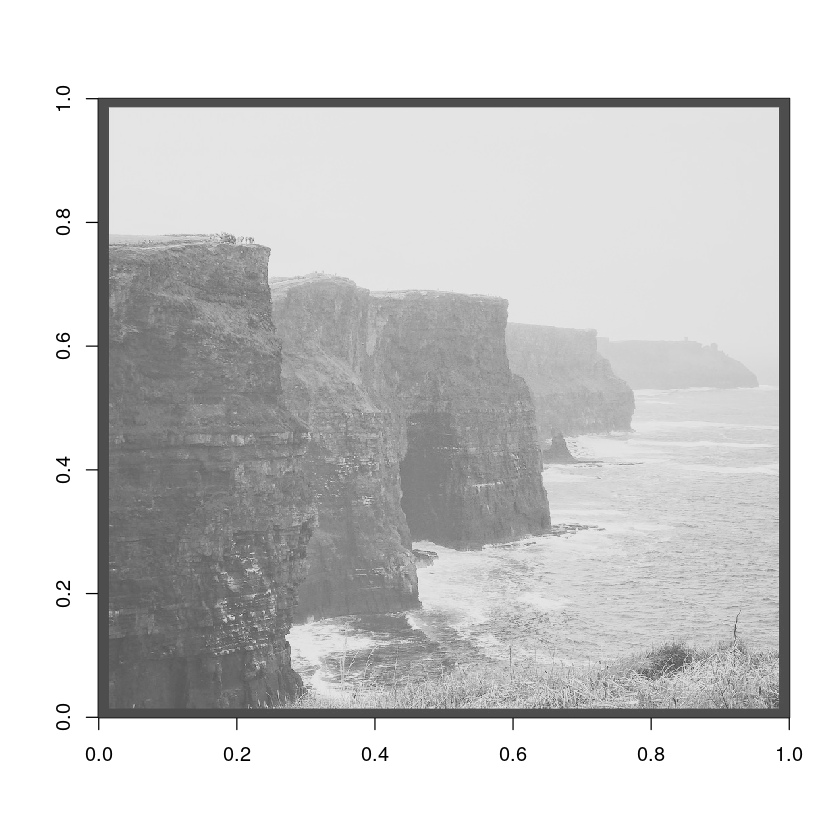

In [5]:
 cliffs1 <- cliffs0[,,1]
 rotate <- function(x){t(apply(x, 2, rev))}
 image(rotate(cliffs1), col=gray.colors(500))

(This may take a while!)

For **color images**, the three layers of the array will usually refer to the RGB values.  Let us read in another image:

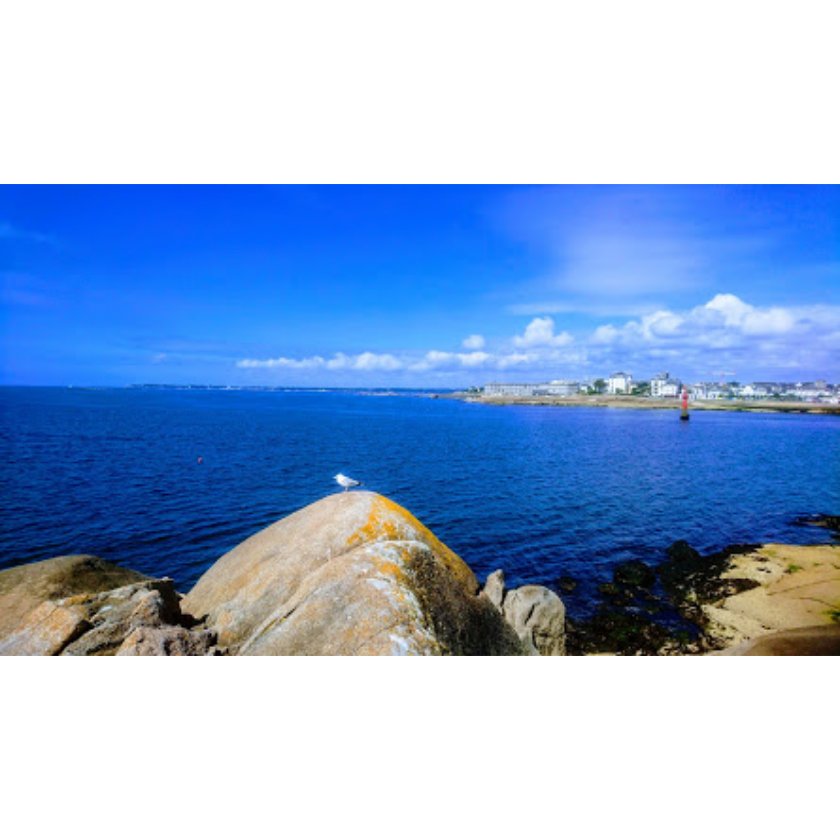

In [6]:
require(OpenImageR)
download.file("http://www.maths.dur.ac.uk/~dma0je/PG/Mix/france.jpg", destfile="france.jpg", mode="wb")
france0 <- readImage("france.jpg")
imageShow(france0)

Apply again the `dim` function, and check, similarly as above, how many pixels in the first and second layer are identical:

In [7]:
dim(france0)
sum(france0[,,1]==france0[,,2])

[1] 250 445   3

[1] 782

If you need to convert a color image to a grey scale image, the three layers can be weighted via 0.21 R + 0.72 G + 0.07 B (Luminosity method). Do this. Save the outcome into an object `france1` and apply `imageShow`: 

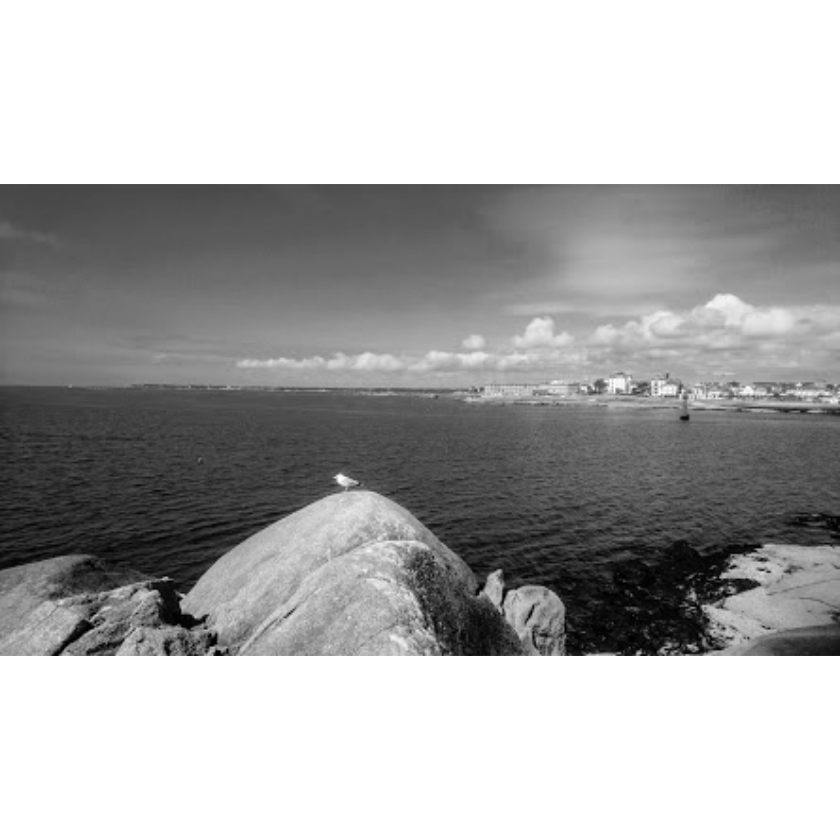

In [8]:
france1<- 0.21*france0[,,1]+0.72*france0[,,2]+0.07*france0[,,3]
imageShow(france1)

#### Clustering and segmentation in (1-D) grey scale feature space

We return, for now, to the analysis of grey scale images, and continue with preparing the image with the cliffs for statistical processing. Firstly, the current 1024 x 1024 image is still quite large to deal with. We resize it via

In [9]:
cliffs <- resizeImage(cliffs1, 256, 256, method = "nearest")

We then need to transform the matrix into a data frame:

In [10]:
Cliffs<- array2df(cliffs)
dim(Cliffs)
names(Cliffs)
head(Cliffs)

[1] 65536     3

[1] "cliffs" "d1"     "d2"

,cliffs,d1,d2
,<dbl>,<dbl>,<dbl>
1,0,1,1
2,0,2,1
3,0,3,1
4,0,4,1
5,0,5,1
6,0,6,1


where the first column contains the grey scales and the other two columns contain the coordinates. Visualize the grey scale distribution (in `Cliffs$cliffs`) through a histogram:

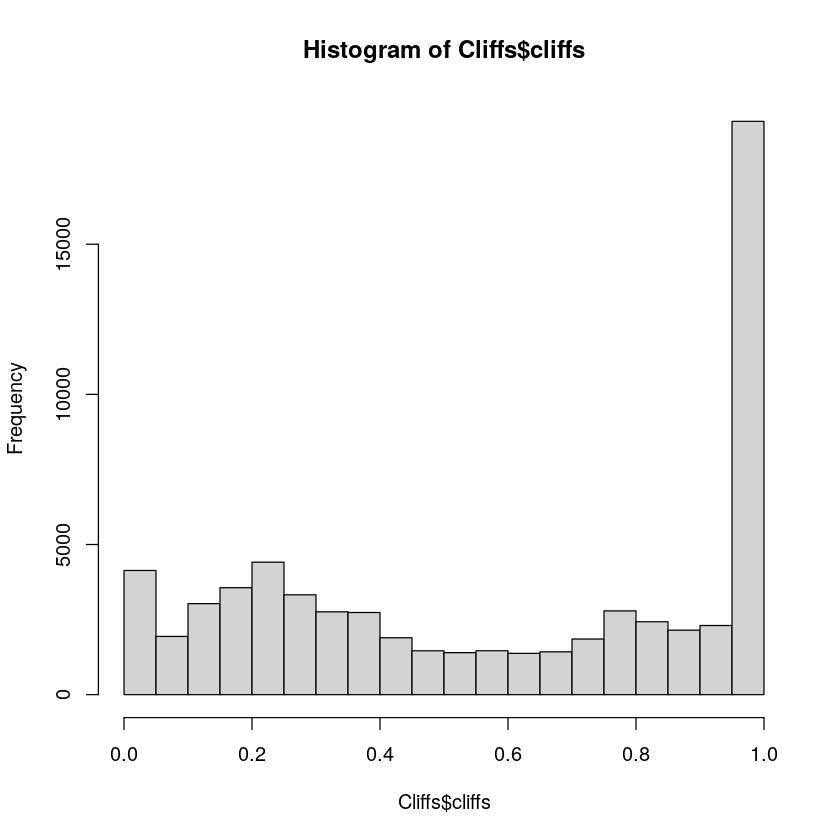

In [11]:
hist(Cliffs$cliffs)

We see that there are three or four clusters in the data, with the leftmost bar representing the black image frame.

To identify the clusters, any clustering method can be used. We begin with k-means. Apply `kmeans` with its default options and three (or four) clusters on `Cliffs$cliffs`, and save the resulting object into `fitcliffs.KM`. Apply the `names` function on the fitted object.

**Note**: Some parts of the notebook downwards from here have been commented out in order to reduce the Validation time of the notebook.

In [12]:
fitcliffs.KM<- kmeans(Cliffs$cliffs, 3)
names(fitcliffs.KM)

The relevant results (for us) are in the component `$centers`, which gives the three cluster centers, and the component `$cluster`, which tells which center is closest to each data point. Display both of these (non-graphically). For the latter, the `table` function is useful.

In [13]:
fitcliffs.KM$centers
table(fitcliffs.KM$cluster)

The trick of cluster-based image segmentation is now, for each pixel,  to *replace the original grey scales by the grey scale corresponding to their respective cluster center*. This can be done very efficiently through the following code. Uncomment it, and make it clear to yourself what it does! 

In [14]:
post.cliffs.KM<- fitcliffs.KM$centers[fitcliffs.KM$cluster]
table(post.cliffs.KM)

Finally, the long vector of grey scales needs to be transformed back into an image. Being unaware of an existing, automated function for that purpose, I provide one:

In [15]:
vector2image <- function(image.vector, show=TRUE, width=NULL){
  N<-length(image.vector)
  D<- sqrt(N)
  if (is.null(width)){
    if ((D %%1) !=0){
        stop("This is not a square image so you need to give the image width")
      } else {
         width<- D
      }
  }
  
  height<- N/width 
  image.matrix<- matrix(image.vector, nrow=height, ncol=width)
  
  if (show) {
    require(OpenImageR)
    imageShow(image.matrix)
  }
  return(image.matrix)
}

Then, we reconstruct the `segmented' image via

In [ ]:
KM.cliff.image<- vector2image(post.cliffs.KM, show=FALSE)
class(KM.cliff.image)
dim(KM.cliff.image)
imageShow(KM.cliff.image)

We see that the segmentation is not very good. A first attempt could be to change the type of algorithm used to execute k-means.

This can be done through the option `algorithm` in function `kmeans`, for instance to `"Lloyd"` or ` "MacQueeen"`.  **Try this**! 

In [17]:
# ?kmeans
# ...

Larger differences in segmentation can be expected when going for an entirely different clustering algorithm. Let us now use EM for Gaussian mixtures as implemented previously.

We need tor this the R code as from lecture part 2:

In [18]:
  estep <- function(dat, p, mu, sigma){         
   n <- length(dat)
   K <- length(mu) 
   W <- matrix(0, n,K)
   for (i in 1:n){
        W[i,]<- p/sigma*exp(-1/(2*sigma^2)*(dat[i]-mu)^2)/sum( p/sigma*exp(-1/(2*sigma^2)*(dat[i]-mu)^2))
      }
  return(W)
 }

mstep <- function(dat, W){                    
   n <- dim(W)[1]
   K <- dim(W)[2]
   
   p  <- apply(W,2,sum)/n
   mu <- apply(W*dat,2,sum)/apply(W,2,sum)
  
   diff <-matrix(0,n, K)
   for (k in 1:K){ diff[,k]<- (dat -mu[k])^2  }
   var   <- apply(W*diff,2,sum)/apply(W,2,sum)
   sigma <- sqrt(var)

  return(list("p"=p, "mu"=mu,  "sigma"=sigma))
} 

em <- function(dat,K, steps=400){                   
  p     <- rep(1/K,K)
  mu    <- quantile(dat, probs= (1:K)/K-1/(2*K))  
  sigma <- rep(sd(dat), K)
  
  s <- 1
  while (s <=steps){
    W   <- estep(dat, p, mu, sigma)
    fit <- mstep(dat, W)
    p   <- fit$p
    mu  <- fit$mu
    sigma <-fit$sigma
    s   <- s+1
 }
    fit<- list("p"=p, "mu"=mu, "sigma"=sigma,  "W" =W)
 return(fit)  
 }


Apply the `em` function with three (or four) components on `Cliffs$cliffs`, and save the fit into an object `fitcliffs.EM`. Display the resulting parameter estimates (non-graphically).

In [19]:
fitcliffs.EM <- em(Cliffs$cliffs, K=3, steps=200)
fitcliffs.EM[c("p", "mu", "sigma")]

To visualize the fitted mixture, we use again the function provided in the lecture.

In [20]:
plot.mix<- function(dat, p, mu, sigma, breaks=25, dens=TRUE, ngrid=401, ...){
  try<-  hist(dat, breaks=breaks,  plot=FALSE)
  hist(dat, breaks=breaks, freq=FALSE, ylim=c(0, max(try$density)*1.3), col="grey93" , border="grey85",...)
  r <- diff(range(dat))
  grid<- seq(min(dat)-0.15*r, max(dat)+0.15*r, length=ngrid)
  K<- length(p)
  if (length(sigma)==1){
    sigma<-rep(sigma, K)
  }
  grid.mat<- matrix(0, ngrid,K)
  for (j in 1:K){
    grid.mat[,j]<- p[j]*dnorm(grid, mu[j], sigma[j])
  }
  for (j in 1:K){
    lines(grid, grid.mat[,j], col=j+1, lwd=2)
  }
  if (dens){
    lines(grid, apply(grid.mat,1, sum), col=1,lwd=2)
  }   
  invisible()  
}



Apply this function onto the fitted mixture from our cliffs image.

In [21]:
plot.mix(Cliffs$cliffs, fitcliffs.EM$p, fitcliffs.EM$mu, fitcliffs.EM$sigma, dens=FALSE)

We clearly see the fitted three components. The next task, is, again, to replace the original grey scales by the grey scale corresponding to their respective cluster center. For mixtures, this is done by allocating *each observation that component to which it belongs with highest probability*.  This information is contained in the weight matrix `W`. Display the first six rows of that matrix.

In [22]:
head(fitcliffs.EM$W)

It is cumbersome to carry out this allocation step manually, so we devise a function for it.

In [23]:
post.em<-function(mu, W){
  n<- dim(W)[1]
  K<- dim(W)[2]
  post.image.class<- rep(0,n)
  post.image.tone <- rep(0,n)
  for (i in 1:n){
    post.image.class[i]<-which.max(W[i,])
  }
  post.image.tone <- mu[post.image.class]
  return(list("class"=post.image.class, "tone"=post.image.tone))
}

Now, uncomment the following to execute this function.

In [24]:
post.cliffs.EM<- post.em(fitcliffs.EM$mu, fitcliffs.EM$W)$tone
table(post.cliffs.EM)

Note this is a vector of length 65536 which only contains three different values. Finally, the vector needs to be mapped back to a matrix. You can do this through the function `vector2image` in the same way as we did for k-means:

In [25]:
EM.cliff.image<- vector2image(post.cliffs.EM, show=FALSE)
dim(EM.cliff.image)
imageShow(EM.cliff.image)

You should now see the "segmented" image. You should see that the segmentation has been a partial success, with sky, water, and rocks somewhat identified, but with a considerable proportion of "contaminating" pixels throughout the image. We can address this problem through an appropriate *filters*.

####  Mode filtering

The idea of a mode filter is to get rid of little contaminations within segments by replacing such "contaminated" pixels with a majority vote of neighboring pixels. A simple implementation of a mode filter is given below.

In [26]:
neighbors<-function(d1,d2, j,k, include.center=TRUE){
  neigh<-matrix(NA,0,2)
  if (include.center){
    neigh<-rbind(neigh, c(j,k))
  } 
      if (j>1){neigh<-rbind(neigh, c(j-1,k))}
      if (j<d1){neigh<-rbind(neigh, c(j+1,k))}
      if (k>1){neigh<-rbind(neigh, c(j, k-1))}
      if (k<d2){neigh<-rbind(neigh, c(j,k+1))}
  
  return(neigh)   
  }

mode.filter<-function(image.labels, include.center=TRUE){
  # image.labels is a d1 x d2 matrix of class labels
   require(pracma)
   d<-dim(image.labels)
   Modes<-matrix(0,d[1], d[2])
   neighbors.jk<-NULL
   for (j in 1:d[1]){
     for (k in 1:d[2]){
      neighbors.jk<-neighbors(d[1],d[2],j,k, include.center)      
      neighbor.labels<-NULL
      neighbor.labels<- image.labels[neighbors.jk]
      Modes[j,k]<-Mode(neighbor.labels)
    }
  }
  return(Modes)
}

Apply function `mode.filter` onto `KM.cliff.image` and `EM.cliff.image`, and in each case use
`imageShow` to visualize the final image:

In [ ]:
KM.cliff.filter<-mode.filter(KM.cliff.image)
imageShow(KM.cliff.filter)

In [ ]:
EM.cliff.filter <- mode.filter(EM.cliff.image)
imageShow(EM.cliff.filter)

#### Clustering and Segmentation in (3-D) RGB space

So far we have only used grey scales for the clustering. If we would like to do carry out the segmentation on an color image (for instance, the original `france.jpg` image above), we need to carry out the clustering in the 3D RGB space. The procedure is pretty analogous to before; the only real difference being that
`vector2image` is now applied layer by layer. **Try this!** (It is suggested to use k-means, as mixture models can take quite long to fit.)


In [29]:
France0<-array2df(france0)
dim(France0)
head(France0)
France<- cbind(France0[France0$d3==1, 1], France0[France0$d3==2, 1], France0[France0$d3==3, 1])
head(France)

fitfrance.KM<- kmeans(France, 4)
fitfrance.KM$centers
post.france.KM<- fitfrance.KM$centers[fitfrance.KM$cluster,]
head(post.france.KM)
KM.france.image<-array(0,dim=dim(france0)) 
dim(KM.france.image)
for (j in 1:3){
KM.france.image[,,j]<- vector2image(post.france.KM[,j], width=445)
}
imageShow(KM.france.image)